In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.8 MB/s eta 0:00:00


In [4]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from datasets import load_dataset, DatasetDict

# Load dataset
ds = load_dataset("Jiwonny29/elementalhero")

# Organize into a single DatasetDict
ds = DatasetDict({
    'train': ds['train'],
    'test': ds['test']
})

Generating train split:   0%|          | 0/114 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29 [00:00<?, ? examples/s]

In [6]:
ds['train']

Dataset({
    features: ['image', 'id', 'name', 'type', 'desc', 'atk', 'def', 'level', 'race', 'attribute', 'archetype', 'image_url', 'image_path', 'simplified_type'],
    num_rows: 114
})

In [7]:
ds['test']

Dataset({
    features: ['image', 'id', 'name', 'type', 'desc', 'atk', 'def', 'level', 'race', 'attribute', 'archetype', 'image_url', 'image_path', 'simplified_type'],
    num_rows: 29
})

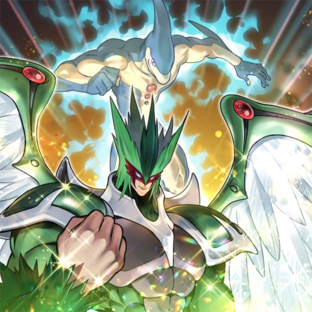

In [8]:
example = ds['train'][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.5*width), int(0.5*height))))

In [9]:
example["desc"]

'Shuffle 1 "Elemental HERO" or "Neo-Spacian" monster you control into the Deck, and if you do, Special Summon 1 "Elemental HERO" or "Neo-Spacian" monster with a different name from your Deck. You can banish this card from your GY; shuffle from your GY into the Deck, either 1 "Elemental HERO" monster and 1 "Neo-Spacian" monster, OR 1 "Elemental HERO Neos", then draw 1 card. You can only use each effect of "EN Shuffle" once per turn.'

In [10]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["desc"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # Generate attention mask
        attention_mask = encoding["input_ids"].clone()
        attention_mask[attention_mask != self.processor.tokenizer.pad_token_id] = 1

        encoding["attention_mask"] = attention_mask

        return encoding

In [11]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
train_dataset = ImageCaptioningDataset(ds['train'], processor)

In [13]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [16]:
processor.decode(batch["input_ids"][0])

'[CLS] cannot be normal summoned or set. must be special summoned ( from your hand ) by sending 1 face - up " elemental hero neos " and 1 face - up " yubel " you control to the graveyard, and cannot be special summoned by other ways. this card cannot be destroyed by card effects. at the end of the damage step, if this card battled an opponent\'s monster : inflict damage to your opponent equal to the atk of the monster it battled, and you gain life points equal to that monster\'s def. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [ ]:
import numpy as np
from PIL import Image

# Load an image. For example, specify the image file path in 'image_path'.
image = Image.open('/content/drive/MyDrive/213326.jpg')

# Convert the image to a numpy array.
image_array = np.array(image)

# Calculate the mean and standard deviation for each channel of the image.
mean = np.mean(image_array, axis=(0, 1))
std = np.std(image_array, axis=(0, 1))

print("Mean:", mean)
print("Std:", std)

Mean: [152.65617552  99.48618559  49.95973044]
Std: [79.87762027 60.99149622 51.37972661]


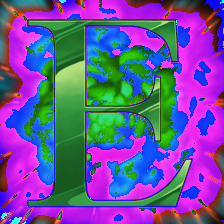

In [ ]:
from PIL import Image
import numpy as np

MEAN = np.array([152.65617552, 99.48618559, 49.95973044]) / 255
STD = np.array([79.87762027, 60.99149622, 51.37972661]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [17]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [18]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.1906, grad_fn=<NllLossBackward0>)

In [19]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 11.898789405822754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 10.286624908447266


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 10.036798477172852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.802699089050293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.486692428588867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.323049545288086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.18661880493164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.9578857421875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.74826431274414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.64466381072998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.54576587677002


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.283891677856445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.058363914489746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.114688873291016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.988944053649902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.947967529296875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.680363178253174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.748092174530029


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.683452129364014


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.483451843261719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.31117057800293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.292403221130371


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.9943060874938965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.983431816101074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.920959949493408


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.783821105957031


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.728816032409668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.634986400604248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.45488977432251


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.354396343231201


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.3891730308532715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.245726585388184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.106020927429199


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.157306671142578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.957298278808594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.779113292694092


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.7841105461120605


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.553597927093506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.547426223754883


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.542803764343262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.426474094390869


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.277449131011963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.151583194732666


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.104484558105469


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.903581142425537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.857030391693115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.766779899597168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.731794357299805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.500592231750488


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.430168628692627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.428245544433594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.246462821960449


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.1107025146484375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.102348327636719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.924830913543701


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.880300521850586


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.6750380992889404
Epoch: 1


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.554079055786133


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.5213279724121094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.4188830852508545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.275099992752075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.1455154418945312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.0904557704925537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.9906063079833984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.952023506164551


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.796804666519165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.651358127593994


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.6211395263671875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.4366559982299805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.424232244491577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.332543134689331


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.317838191986084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.092010021209717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.109388589859009


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.2429141998291016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.81305730342865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.805796504020691


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.6927365064620972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.6435717344284058


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.642734169960022


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.5326155424118042


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.3720167875289917


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.4044641256332397


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.1636962890625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.3484950065612793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.2660399675369263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.204741358757019


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.1953216791152954


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.9810072183609009


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.9013997316360474


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.9315946698188782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7261094450950623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.946025550365448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.8592809438705444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.0242129564285278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.0993319749832153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7770114541053772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.101249098777771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.0133934020996094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6497032642364502


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.8174636363983154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6393047571182251


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4670988619327545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7125766277313232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5251309871673584


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5865445137023926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4853420555591583


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.40546634793281555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5014211535453796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7679886221885681


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5055449604988098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5967323780059814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7283188700675964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.8892989158630371
Epoch: 2


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.41940200328826904


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7643311619758606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5940937399864197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4161568880081177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.42008915543556213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.438069611787796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3267833888530731


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5066732168197632


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.34655070304870605


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.36849167943000793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3868345022201538


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4849626421928406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3921724557876587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6356146931648254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.589742124080658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7872258424758911


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3760845363140106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5496208071708679


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4316495656967163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35253822803497314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4988309442996979


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2743295431137085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.28557851910591125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2497071921825409


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.28610891103744507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4119378328323364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.33351975679397583


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5240318179130554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.44221433997154236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25208210945129395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5126923322677612


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4319306015968323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5606356859207153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.43353942036628723


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18588268756866455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5489060878753662


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3328494429588318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22499944269657135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2268509566783905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5139749646186829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2492067515850067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5335326194763184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2068440318107605


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35643279552459717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19203558564186096


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3002483546733856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35663026571273804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2708488702774048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25639066100120544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5818861126899719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5802974700927734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4155239164829254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6000657677650452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.43598029017448425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24505186080932617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26520445942878723


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.36063680052757263
Epoch: 3


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14223869144916534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.274211585521698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2964167296886444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2155679613351822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4614250063896179


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.39729395508766174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3441909849643707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24416734278202057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5111160278320312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17461304366588593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4799785912036896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27457380294799805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23415879905223846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.45641201734542847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3560104966163635


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27843669056892395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.381808340549469


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18058840930461884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35429033637046814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23995956778526306


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.46603265404701233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.45276492834091187


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1785648912191391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4613237977027893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23095309734344482


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35284897685050964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23248261213302612


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16849419474601746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19323767721652985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4537172019481659


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5344822406768799


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27135777473449707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.33902642130851746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.40650632977485657


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.265889436006546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26590749621391296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2771567404270172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3408576250076294


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18421335518360138


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3595488965511322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16956555843353271


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.534913182258606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25903451442718506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20269761979579926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2057739943265915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2549422085285187


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.38852405548095703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2990339398384094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13750678300857544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4596100151538849


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.29099851846694946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1457429677248001


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23753948509693146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23270635306835175


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1788390874862671


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20069867372512817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1852770894765854
Epoch: 4


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.36648648977279663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17418120801448822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19618701934814453


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5236024260520935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1189865693449974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2842514216899872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.48406192660331726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13702575862407684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20455101132392883


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21813835203647614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17059141397476196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.28849124908447266


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.28149574995040894


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26107603311538696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08842529356479645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2029721438884735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.32215675711631775


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.179354727268219


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13617318868637085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.316486120223999


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13664115965366364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18499116599559784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18100522458553314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16502957046031952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3117039203643799


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1765231192111969


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3485470414161682


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19732332229614258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3480288088321686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2108655720949173


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35083767771720886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17636828124523163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25356972217559814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10853534936904907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.36387866735458374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12369336932897568


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2118963748216629


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15055033564567566


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2169809341430664


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.31912553310394287


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1420113891363144


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23070180416107178


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1944202035665512


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07962338626384735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11912010610103607


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24770846962928772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1966806948184967


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3761269450187683


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4030167758464813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2782476842403412


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4055050313472748


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2734910249710083


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25286033749580383


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16859404742717743


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3455910384654999


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21277278661727905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3939143419265747
Epoch: 5


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22433848679065704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12135763466358185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26815229654312134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25020331144332886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2340376228094101


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10394849628210068


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23855896294116974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19421282410621643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10115783661603928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15035803616046906


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1735018938779831


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13215862214565277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3803180456161499


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25944194197654724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2028678059577942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12765982747077942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.39955437183380127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25196319818496704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1282562017440796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23326389491558075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13919205963611603


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16497892141342163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15866956114768982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.43178343772888184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22306856513023376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1398698091506958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19957785308361053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16108551621437073


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12982667982578278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09196152538061142


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09965365380048752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10327550768852234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16243983805179596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12749776244163513


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22669529914855957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2651847004890442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19493885338306427


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1030588150024414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21457058191299438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20519085228443146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21371012926101685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12333595752716064


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2981460988521576


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2334776371717453


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2883249819278717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10030464828014374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19620846211910248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3277339041233063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1830407679080963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.39971497654914856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.40115460753440857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09751754254102707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24822856485843658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10433030128479004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13673551380634308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08900588750839233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3231852352619171
Epoch: 6


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27203497290611267


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1511325240135193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2023090273141861


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18149493634700775


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20678648352622986


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22455590963363647


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23312897980213165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11025261133909225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19696177542209625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25122541189193726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08129700273275375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22235247492790222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09524545073509216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09575966000556946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18484170734882355


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15626274049282074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12422392517328262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2006072849035263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2635757625102997


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1145012378692627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14035341143608093


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16353201866149902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19801194965839386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16087324917316437


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22633709013462067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10369556397199631


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09003403782844543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1273723691701889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.261150062084198


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.048181455582380295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1217527687549591


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09435200691223145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0707174614071846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22135040163993835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19224387407302856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2392115592956543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20481587946414948


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15175940096378326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20694124698638916


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23512031137943268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10450177639722824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09550902992486954


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24864909052848816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11616409569978714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10167377442121506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26404768228530884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08561985194683075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13235147297382355


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3405357003211975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1412891447544098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05210407078266144


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20925575494766235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2617923319339752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11763016134500504


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1416427046060562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18962706625461578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12719152867794037
Epoch: 7


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17106269299983978


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1303107738494873


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07044994831085205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17216604948043823


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05955500155687332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2703944444656372


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14601710438728333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10441207140684128


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10690426826477051


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10694865882396698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17277738451957703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2626486122608185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07036446034908295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12434551864862442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14779575169086456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13329550623893738


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21923327445983887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11708993464708328


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2174781858921051


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16578343510627747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07651768624782562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13951854407787323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06743644922971725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12935131788253784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09592700749635696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1386626660823822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1553732007741928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12603038549423218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061758965253829956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07891784608364105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2829959988594055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15918196737766266


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11085310578346252


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09145177900791168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16491158306598663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12260962277650833


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09620495140552521


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18223267793655396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18198731541633606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07381678372621536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18790830671787262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08479750901460648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10956408828496933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12732090055942535


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1664315164089203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1631793975830078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17507977783679962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06025908514857292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25901252031326294


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14207132160663605


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11171574145555496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1602625697851181


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1577899008989334


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13405777513980865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20095346868038177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08744176477193832


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06469666957855225
Epoch: 8


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14345213770866394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14006277918815613


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0931568518280983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1136707216501236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07769426703453064


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09499944001436234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09904927760362625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11691956222057343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08945906162261963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06596166640520096


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07293931394815445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11778312921524048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03691622242331505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12505844235420227


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17672772705554962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12782353162765503


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06267911195755005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15993891656398773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07092100381851196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07916862517595291


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10047511011362076


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08406554162502289


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22605057060718536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18576428294181824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.085984967648983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05532464757561684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10837581753730774


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16826443374156952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0935850590467453


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1375650316476822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19839473068714142


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051049500703811646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13983254134655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07565746456384659


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14419490098953247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.205470010638237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0539139024913311


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16538682579994202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24719320237636566


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16319236159324646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04043897986412048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06256598979234695


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05160220339894295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0937289148569107


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20121639966964722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10071693360805511


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17050372064113617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1162850558757782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12366250902414322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.173552468419075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15099725127220154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08426712453365326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11626576632261276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08829798549413681


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06911396235227585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0690222829580307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.042254697531461716
Epoch: 9


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13437047600746155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07397866249084473


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06297307461500168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14327837526798248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11650750041007996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08763958513736725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05419879034161568


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12157244235277176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040565233677625656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10257382690906525


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07501549273729324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08091920614242554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10813366621732712


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11976860463619232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13738961517810822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0791366919875145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06842289865016937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08313897997140884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10698413848876953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11690197885036469


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07034905254840851


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07848677039146423


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08109764754772186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07733611017465591


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06022007018327713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08597160875797272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07933473587036133


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06698507815599442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10186806321144104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04782693460583687


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12442199885845184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0830998346209526


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10659582167863846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20289690792560577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05956846475601196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16274267435073853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06257859617471695


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12462805956602097


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17936933040618896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05448411777615547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07629790902137756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06940551847219467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044029928743839264


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15390130877494812


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16129669547080994


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08374997228384018


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12040071189403534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15785160660743713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10490407049655914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04711047559976578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11533953994512558


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13465577363967896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12508760392665863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16268715262413025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05771051347255707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06415896862745285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12940838932991028
Epoch: 10


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10501869022846222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09701074659824371


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0276739951223135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06747608631849289


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06612236797809601


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08786259591579437


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059094417840242386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08608291298151016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04656188189983368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08242704719305038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04356139898300171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059728000313043594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026121927425265312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1218455508351326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11108412593603134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04836206138134003


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09222578257322311


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1073269322514534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06113462522625923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0902109369635582


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09789518266916275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09970977902412415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07276973873376846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08930417895317078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07110518217086792


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0817028358578682


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12261069566011429


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05398714914917946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10348133742809296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04882514476776123


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06398695707321167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10312006622552872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0674930065870285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14588338136672974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05934859439730644


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13225992023944855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05361415445804596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09154483675956726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03694020211696625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08507680147886276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06296076625585556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11468750983476639


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12792418897151947


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06641155481338501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038212936371564865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047235891222953796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07184618711471558


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09626930207014084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12925870716571808


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06361420452594757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1257578283548355


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0910995826125145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0937381386756897


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11846627295017242


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0301267858594656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08505015075206757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07088994234800339
Epoch: 11


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05140603706240654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04881422594189644


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06288459897041321


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08821433037519455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06357937306165695


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040652498602867126


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.042222898453474045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04831036180257797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12388455122709274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04808426275849342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07920607924461365


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07801765948534012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1196916401386261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08581840991973877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10739386826753616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07652033865451813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.056007590144872665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08757559955120087


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03898928686976433


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0488203726708889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07553140819072723


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10025357455015182


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06390270590782166


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08073298633098602


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09216763824224472


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06717218458652496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04117894172668457


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06843627244234085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06065421178936958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05494162067770958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03161192312836647


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04868674278259277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09705885499715805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07308045774698257


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.058277953416109085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02831479348242283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04766393080353737


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05488940700888634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11673437803983688


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03602331504225731


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04750078171491623


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08833130449056625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12217369675636292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09632814675569534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04594935104250908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07602213323116302


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045861389487981796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10819156467914581


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04233770817518234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11794011294841766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05532247945666313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07435189187526703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029269739985466003


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08351700752973557


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09760337322950363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03766561672091484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03391542658209801
Epoch: 12


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045891884714365005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04950622469186783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.057220567017793655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06250559538602829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05089320242404938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044196635484695435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11955583095550537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038018811494112015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04584638029336929


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05978202819824219


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04145320504903793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07348933815956116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.060054998844861984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05371202155947685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02641575038433075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028308527544140816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03152402117848396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03696001321077347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.062408123165369034


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05204174667596817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06451315432786942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09985121339559555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032003458589315414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06415106356143951


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09581252187490463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03065737709403038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07389255613088608


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04849039390683174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04188286513090134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059961024671792984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06987052410840988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0527869388461113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06481041759252548


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07699509710073471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07270567864179611


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04675831273198128


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09601956605911255


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07875199615955353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04761924222111702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07204792648553848


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07686357200145721


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.058638546615839005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028623564168810844


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07184283435344696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07239535450935364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05336497351527214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039958253502845764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04096316918730736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1154823750257492


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09682174772024155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05752255767583847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06757070124149323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05740358307957649


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0718245655298233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03741409257054329


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11033108830451965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.042699143290519714
Epoch: 13


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04912124574184418


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04870644211769104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03885829821228981


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03208736702799797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019225461408495903


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07952036708593369


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03340431675314903


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04223233088850975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07992371171712875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05825178697705269


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03646983578801155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027356332167983055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038860075175762177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04771801829338074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029941994696855545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05167336389422417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05771526321768761


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03702595457434654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0465211383998394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04282417893409729


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03331126645207405


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044236425310373306


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031060028821229935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.058589156717061996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.052946675568819046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04995707795023918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05016995221376419


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04890047758817673


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04239995777606964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05164984241127968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04762664809823036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030109621584415436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08485104888677597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06536813825368881


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08813188225030899


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03154953196644783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04578601196408272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040195532143116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04835372790694237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05751490965485573


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0369262620806694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04290778934955597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06747603416442871


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1093013808131218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03362872079014778


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07430117577314377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05080017074942589


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06350092589855194


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06762786209583282


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0569734200835228


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1030685156583786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047468263655900955


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.056124668568372726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08447036147117615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04452574998140335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.052075013518333435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06983288377523422
Epoch: 14


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045328978449106216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03480008617043495


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05292777344584465


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051222097128629684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05403611436486244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02559519372880459


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033887386322021484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08594666421413422


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04901989921927452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04156806692481041


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08048004657030106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03019849956035614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037861648947000504


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061795882880687714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.062273893505334854


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03945053368806839


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06554857641458511


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05788816511631012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019165469333529472


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.056388724595308304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06938055157661438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0463656522333622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037232931703329086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04236241430044174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05676692724227905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03625260293483734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05808121711015701


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03235352039337158


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03913382440805435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061123210936784744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0652984082698822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03843635320663452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06807880103588104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033383559435606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03709351271390915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05067085847258568


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03293745964765549


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03643308952450752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05996076762676239


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03645232319831848


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029995955526828766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05167748034000397


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03722601383924484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04894673824310303


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041998494416475296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07718291878700256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.043670494109392166


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.049941256642341614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022417200729250908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029853612184524536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025100544095039368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0409698560833931


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051308028399944305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03143807500600815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03966977447271347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046122923493385315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06380115449428558
Epoch: 15


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08371322602033615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032863467931747437


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029510479420423508


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04362378641963005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030716674402356148


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06176548823714256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020888764411211014


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025114724412560463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.048766933381557465


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033855002373456955


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04917622730135918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059379830956459045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04518028721213341


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03545461222529411


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024810101836919785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02621637098491192


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037575848400592804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03905301168560982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04752492532134056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026922812685370445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02755339816212654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03729312866926193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05796188488602638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026059012860059738


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039547741413116455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05972877889871597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.055947188287973404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06691337376832962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03765161335468292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03311052918434143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02600175328552723


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03441188111901283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04537985101342201


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07868526875972748


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03566572070121765


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03717896342277527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0347234271466732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05302784591913223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04214370623230934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027579382061958313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022353969514369965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02424856647849083


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02676384337246418


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06274517625570297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.054424069821834564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03495164215564728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029033754020929337


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032763294875621796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02679518610239029


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05373785272240639


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04724188521504402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045785028487443924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06603430956602097


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037553008645772934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059756889939308167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03687187284231186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05498288944363594
Epoch: 16


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02986447885632515


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.049981582909822464


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025222795084118843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07904718816280365


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04723651707172394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047904860228300095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0266159325838089


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0346105620265007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02542325109243393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027858877554535866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04419587552547455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03403294086456299


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06378712505102158


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033653710037469864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05246616154909134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02704177424311638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027587495744228363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04041644558310509


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04213855788111687


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02920539863407612


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05233316496014595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.057858843356370926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025011776015162468


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02174597606062889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03216129541397095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03283515200018883


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030859675258398056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021248795092105865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06221545860171318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03427416831254959


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023426935076713562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03651038929820061


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05704660341143608


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02835792861878872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039323266595602036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04087582603096962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02736121043562889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.054006025195121765


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044454075396060944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04126335680484772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02353380061686039


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04328206181526184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047737106680870056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05017676576972008


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03161446750164032


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04905495420098305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03926215320825577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04863940179347992


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03812158852815628


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033283550292253494


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06070088967680931


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041356828063726425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040824390947818756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02770460583269596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03324388340115547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04124801233410835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0197810810059309
Epoch: 17


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03305208310484886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028930243104696274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023283669725060463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023020287975668907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032292816787958145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04256037622690201


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025409698486328125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05613861605525017


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015299540013074875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03274383023381233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028744621202349663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03188919275999069


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027355946600437164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034276898950338364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04348773509263992


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04488370940089226


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04525488615036011


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03413914889097214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0290056262165308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029559385031461716


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035332273691892624


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02849690243601799


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03523358330130577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024098703637719154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03337670862674713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034140437841415405


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028069190680980682


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021586455404758453


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03612854331731796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035348404198884964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038900360465049744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04911142960190773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03301620855927467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02135922573506832


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038998913019895554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03540988266468048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025273676961660385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05097808316349983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035203784704208374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035260193049907684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02702990360558033


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03350991755723953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046123206615448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023655423894524574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04582234472036362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04712891951203346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0221717432141304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03089269809424877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0506531186401844


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0411752350628376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06367609649896622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06059340015053749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05584751442074776


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03442596644163132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023136600852012634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026735182851552963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.036890480667352676
Epoch: 18


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02485819347202778


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020403115078806877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022073134779930115


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024634625762701035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04658735916018486


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019674235954880714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04100760444998741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04205307736992836


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03826497122645378


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024289077147841454


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03908075764775276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025351589545607567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027426619082689285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026890141889452934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.040524572134017944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03768344968557358


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027211030945181847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04143435135483742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02725427970290184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021833710372447968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018191609531641006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035097312182188034


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03782620280981064


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033869653940200806


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02705523557960987


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03584916889667511


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02154298685491085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030560240149497986


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02508999966084957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032314956188201904


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035880036652088165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02726304717361927


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035589348524808884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039099790155887604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037130847573280334


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045691054314374924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024497324600815773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03965597599744797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029586732387542725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027394916862249374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03873121365904808


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03862879052758217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06444787234067917


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02273969165980816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.055178672075271606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022905321791768074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04115084186196327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026314767077565193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02876383624970913


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027042686939239502


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025557762011885643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04150889441370964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02436690963804722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04621811956167221


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022498708218336105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03379068896174431


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04705914482474327
Epoch: 19


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020773926749825478


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037243131548166275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02268344722688198


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026477182283997536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030679913237690926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04204253479838371


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023104993626475334


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01958894357085228


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019940977916121483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04281971603631973


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03368455544114113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02274186722934246


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025912413373589516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021540146321058273


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02782416343688965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04044834151864052


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02680576965212822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021640026941895485


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03067224845290184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029421096667647362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031378768384456635


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01971103809773922


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022661954164505005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018662218004465103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015372416004538536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03500267490744591


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03588692098855972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024066129699349403


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025587493553757668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02278711088001728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028262056410312653


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030219851061701775


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022986287251114845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02710288017988205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046470366418361664


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025113223120570183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021464815363287926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023919468745589256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039609041064977646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01799241080880165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028211964294314384


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029216967523097992


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038929663598537445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020177969709038734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028378166258335114


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04868747293949127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02529055066406727


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03136369213461876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031704362481832504


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03779657185077667


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014378974214196205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037385400384664536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020750975236296654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0420738123357296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023329174146056175


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031159089878201485


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02443174086511135
Epoch: 20


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029819829389452934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029931316152215004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021042529493570328


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021217254921793938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025558222085237503


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02056169882416725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02308471128344536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021624857559800148


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03091457672417164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031893931329250336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03670652210712433


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04300873726606369


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01225495059043169


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022413011640310287


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022628961130976677


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02304232493042946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039563074707984924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028776980936527252


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029853735119104385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026140891015529633


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01726851426064968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022332923486828804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01886172965168953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021698687225580215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029277799651026726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030351907014846802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027567805722355843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02747509442269802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025323273614048958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02633657120168209


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019680844619870186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022301217541098595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02433611825108528


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037030138075351715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02571769803762436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03400186821818352


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025316907092928886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027811730280518532


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02094241790473461


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02030211314558983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028485232964158058


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022679122164845467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025401940569281578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039600685238838196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023799017071723938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023549184203147888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02665320597589016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02432178519666195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021245848387479782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02451200969517231


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030152928084135056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028349028900265694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03273641690611839


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.036015208810567856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026881234720349312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032651592046022415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026017608121037483
Epoch: 21


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014014855958521366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024337029084563255


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024914130568504333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026518454775214195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018651071935892105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02453789860010147


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01898953504860401


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024662483483552933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024415653198957443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022970614954829216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02367633953690529


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0218232199549675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01772460713982582


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024585535749793053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029681483283638954


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020536866039037704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01692754030227661


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019024593755602837


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01767837069928646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02023213915526867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016656331717967987


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03169938176870346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018037857487797737


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021891554817557335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023955080658197403


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03780548274517059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029771456494927406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023212440311908722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030062053352594376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027865538373589516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0309564471244812


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029527122154831886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026498571038246155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016403764486312866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035366710275411606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03193559870123863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027832964435219765


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026790102943778038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023972561582922935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02369762770831585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03315733000636101


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04571620374917984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025594037026166916


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025789182633161545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0181654654443264


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01979014463722706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028617992997169495


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02172897383570671


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024571018293499947


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02284824475646019


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018351757898926735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020955100655555725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033670082688331604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028759337961673737


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02436038665473461


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026605283841490746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017269693315029144
Epoch: 22


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01865735836327076


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02566208317875862


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021819137036800385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02153443731367588


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020054100081324577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023622864857316017


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02352721057832241


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012790498323738575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01632554642856121


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.036523766815662384


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024692367762327194


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022393155843019485


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02247648499906063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026903832331299782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018876492977142334


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019860466942191124


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016215693205595016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027689121663570404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018872171640396118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02421162649989128


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01842137984931469


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021605031564831734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027465153485536575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014946190640330315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01879655197262764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022407181560993195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022799598053097725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024605028331279755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017794767394661903


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021445179358124733


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033571720123291016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019688917323946953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019357644021511078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025659359991550446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03261623531579971


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019759662449359894


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02431696280837059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020923929288983345


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030512548983097076


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02055690996348858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015743182972073555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0236634761095047


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029180994257330894


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024296464398503304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021832669153809547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023701874539256096


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019831109791994095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022916484624147415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02178121916949749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024791071191430092


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02171359397470951


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018546169623732567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012643512338399887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02159992791712284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021800825372338295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01757318712770939


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029001042246818542
Epoch: 23


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019873417913913727


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02159873954951763


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02313948981463909


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01435984019190073


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018406234681606293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026248624548316002


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03119097650051117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023088542744517326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017322367057204247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015933819115161896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019110526889562607


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018161000683903694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017421910539269447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02307591401040554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020564546808600426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014832389540970325


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01666957698762417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03166130557656288


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017554044723510742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016903258860111237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01723073422908783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023997312411665916


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02054516226053238


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01568423956632614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0201986413449049


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014735154807567596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02640853449702263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020416293293237686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013508887030184269


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025738241150975227


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025652674958109856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01943473517894745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02437335066497326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02532392181456089


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021827727556228638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023435696959495544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023490333929657936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02164543978869915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020542999729514122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01994635909795761


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025947872549295425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02305438742041588


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025841567665338516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016941437497735023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016299109905958176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01990043930709362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0228359904140234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02080722711980343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020279325544834137


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020881546661257744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021175703033804893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02462553046643734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0291418619453907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02232903242111206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02680967189371586


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022684086114168167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022481616586446762
Epoch: 24


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019041983410716057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021205242723226547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023000653833150864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02508809231221676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011962332762777805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019069798290729523


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019610268995165825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015430190600454807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021781425923109055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013482418842613697


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016737595200538635


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02362435683608055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015490776859223843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016150295734405518


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01845160312950611


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023276440799236298


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03002106584608555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016017047688364983


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016610322520136833


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014967920258641243


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021933915093541145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027389293536543846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028024420142173767


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016654228791594505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024396458640694618


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020076198503375053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02687268704175949


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013009879738092422


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014544918201863766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022766202688217163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025008998811244965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011891688220202923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02388039231300354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02625853754580021


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016368871554732323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028363874182105064


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017478948459029198


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013350509107112885


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020578021183609962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02255549654364586


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011984838172793388


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020170100033283234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03232762962579727


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021802613511681557


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021276960149407387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02109052613377571


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024346956983208656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0171032827347517


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020662494003772736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02643934078514576


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017085155472159386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01927183009684086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02379368431866169


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016403352841734886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014427760615944862


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02047131024301052


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024868719279766083
Epoch: 25


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018360966816544533


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02091877907514572


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019767412915825844


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011921051889657974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01913692057132721


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009650042280554771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024524595588445663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017059599980711937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015700053423643112


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020057635381817818


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011542784050107002


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014383933506906033


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019932005554437637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020460005849599838


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017983000725507736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02813602425158024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013778713531792164


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019210483878850937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022840505465865135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027580158784985542


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024354584515094757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013331728987395763


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011749690398573875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013121244497597218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02061614952981472


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012965901754796505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019032776355743408


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01887679100036621


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01632159762084484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014077971689403057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017040779814124107


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020618628710508347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018653014674782753


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023198535665869713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012760089710354805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019765589386224747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02238461561501026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021066119894385338


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01894715055823326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021841641515493393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015300258062779903


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023515596985816956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025548124685883522


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01903950795531273


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017127610743045807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027877425774931908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018250728026032448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01672782190144062


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020691655576229095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019841138273477554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023150119930505753


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022101910784840584


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0153295723721385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016559360548853874


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03099828213453293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027172522619366646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01673039048910141
Epoch: 26


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01234540157020092


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013184904120862484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017102036625146866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01927296817302704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014190787449479103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018775245174765587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016338367015123367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015341650694608688


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01234808936715126


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021804342046380043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027292344719171524


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02214593067765236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010708059184253216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013345541432499886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013649231754243374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017441755160689354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01656089909374714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016872970387339592


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016646763309836388


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014430548064410686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019637277349829674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021715573966503143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018189627677202225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019430654123425484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023637790232896805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014372709207236767


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02389448881149292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015892833471298218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015797745436429977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024241993203759193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015088171698153019


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0169680193066597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019913790747523308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016588326543569565


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01431885827332735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013497673906385899


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018016666173934937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01551486924290657


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016758974641561508


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016087548807263374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013816800899803638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02201893739402294


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021767282858490944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01384268794208765


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021701008081436157


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022858820855617523


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014047576114535332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021176563575863838


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018337121233344078


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012494921684265137


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012150699272751808


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019913645461201668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023051071912050247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01886841654777527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017348768189549446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01512879692018032


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01742827333509922
Epoch: 27


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01709630712866783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014494214206933975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015101585537195206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023983361199498177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021936526522040367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01893611252307892


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016749488189816475


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011444244533777237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01928175613284111


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013824847526848316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01857866905629635


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01906917802989483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012541145086288452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0125637948513031


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022370116785168648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01590477116405964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03164982423186302


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01612532138824463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013686936348676682


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017733793705701828


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013064965605735779


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01962319388985634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013553234748542309


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01906464993953705


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019057542085647583


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02361358143389225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009217191487550735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01773805171251297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01630851812660694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016210369765758514


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014135504141449928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026680205017328262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023946333676576614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01340014673769474


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012468250468373299


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014917880296707153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018053991720080376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015686947852373123


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01875966228544712


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025686126202344894


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021318305283784866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019893433898687363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013442429713904858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025090908631682396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0151619678363204


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020802615210413933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0213957279920578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018802685663104057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01869501732289791


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015435711480677128


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0194050632417202


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013640034943819046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018664730712771416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01815483532845974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016275448724627495


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01806674152612686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012422487139701843
Epoch: 28


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013535914942622185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016711778938770294


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019496669992804527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012430952861905098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01458317507058382


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018645573407411575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015405187383294106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012814825400710106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014000333845615387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019328907132148743


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01837090030312538


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017886653542518616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016792187467217445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013315764255821705


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01767151430249214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008679722435772419


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00978928618133068


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014730952680110931


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020349422469735146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01752648502588272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017130589112639427


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022849764674901962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01379985362291336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011402977630496025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01753418892621994


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01338762417435646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025019170716404915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024725835770368576


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02378612942993641


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01405748538672924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017451288178563118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01807604543864727


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019126979634165764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012235557660460472


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017537996172904968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013008087873458862


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023104151710867882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01092229038476944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024324743077158928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018979264423251152


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01527397520840168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020955566316843033


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012394559569656849


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021681474521756172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024871312081813812


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020650502294301987


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013780035078525543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020607993006706238


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01699352078139782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01887984201312065


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015456133522093296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014152842573821545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01922234334051609


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026335187256336212


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019532734528183937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025661848485469818


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018110986799001694
Epoch: 29


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014586555771529675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013313046656548977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018196890130639076


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018543411046266556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017974354326725006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024443231523036957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0071729933843016624


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011243096552789211


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008764083497226238


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020155873149633408


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021605411544442177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01345239020884037


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01575116626918316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018503760918974876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017720358446240425


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01712706871330738


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018901916220784187


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012967253103852272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012519077397882938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015507787466049194


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015282898209989071


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01862732693552971


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016347607597708702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01758137345314026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01690160483121872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0189767275005579


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018950577825307846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015041290782392025


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015727052465081215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01895516738295555


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014519749209284782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018716610968112946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012380759231746197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016912763938307762


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017121559008955956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01715497113764286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018070613965392113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013391533866524696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018281450495123863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013605840504169464


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01736488938331604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019164711236953735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018680766224861145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00919438898563385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016782913357019424


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014005976729094982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0151129812002182


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015253953635692596


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025772200897336006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01753106154501438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013364385813474655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01956106908619404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022605855017900467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014269539155066013


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013444891199469566


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019919011741876602


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020628953352570534
Epoch: 30


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019335908815264702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01033372525125742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014170809648931026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014240823686122894


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01364914420992136


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015373754315078259


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01140592060983181


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015061000362038612


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016209302470088005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013233824633061886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015903770923614502


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008702978491783142


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011085320264101028


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02231181040406227


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013430282473564148


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01710749790072441


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015115362592041492


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01365431398153305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017964990809559822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012402448803186417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01783151365816593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014813178218901157


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01788504421710968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013222037814557552


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013247276656329632


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01779063791036606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01930421218276024


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010054760612547398


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016021309420466423


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01226363331079483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012275868095457554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022507233545184135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016732849180698395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021938996389508247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00969165749847889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017494602128863335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013952516950666904


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012302725575864315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019099172204732895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016358328983187675


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02049098163843155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018150830641388893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01640085130929947


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022122550755739212


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012182261794805527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01899183727800846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01709035597741604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01622701808810234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018450064584612846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017264747992157936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0231479499489069


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02089749090373516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014854098670184612


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017375703901052475


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013858248479664326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02204200252890587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015410413034260273
Epoch: 31


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01278049685060978


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014390555210411549


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022440198808908463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012376224622130394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015139536932110786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013278808444738388


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01767406053841114


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010242574848234653


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012403147295117378


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012666289694607258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013345357030630112


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009298804216086864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01465750951319933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014872080646455288


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017833685502409935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010986161418259144


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009562377817928791


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010161790996789932


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025141799822449684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010658172890543938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015196692198514938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007594592869281769


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01483819168061018


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016430826857686043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015664689242839813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01701159030199051


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015221657231450081


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017033550888299942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01829751394689083


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014921114780008793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011673093773424625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01328341756016016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016258351504802704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013264178298413754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016420774161815643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013155494816601276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010883402079343796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012947183102369308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02078082598745823


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01855834759771824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009655972942709923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023933200165629387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013055682182312012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014772461727261543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014371257275342941


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01416793279349804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012973681092262268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022588413208723068


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01491605769842863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017023148015141487


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010225361213088036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017796436324715614


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015249854885041714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013319162651896477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015389718115329742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0164171289652586


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01403963752090931
Epoch: 32


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017779048532247543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011152118444442749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013483302667737007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008042735047638416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014602025039494038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007695094216614962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013795427046716213


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011907077394425869


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023439284414052963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009137134999036789


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01052337046712637


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019569849595427513


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014081143774092197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00774736562743783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01693534478545189


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023097943514585495


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01814297027885914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014611981809139252


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014576626010239124


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012477975338697433


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016836153343319893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011666012927889824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009958825074136257


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012480593286454678


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0153283616527915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011949395760893822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020202353596687317


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012274197302758694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010136513970792294


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013557640835642815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012834446504712105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01825784519314766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015186690725386143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014546257443726063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010708707384765148


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016807273030281067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01847175695002079


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019305698573589325


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01881983131170273


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0123223178088665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009195071645081043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01489943265914917


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016441812738776207


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012599259614944458


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013116882182657719


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01389976404607296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01751021295785904


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014858614653348923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014084632508456707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014693737961351871


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01872769184410572


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014132341369986534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012055880390107632


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018461359664797783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01764988899230957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026284102350473404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01288230624049902
Epoch: 33


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01662369817495346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012692340649664402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020841194316744804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013286400586366653


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007727887947112322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012218685820698738


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01956336200237274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012990440241992474


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010415023192763329


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013669527135789394


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01773586869239807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03088664822280407


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014094460755586624


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017475493252277374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014531154185533524


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017535222694277763


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012352908961474895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013642766512930393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010906201787292957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015172691084444523


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017078997567296028


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013881545513868332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01703355833888054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01353362388908863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010835876688361168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016645343974232674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014056025072932243


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014715836383402348


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012299890629947186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012787357904016972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011147051118314266


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01586243137717247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01587163470685482


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016593793407082558


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018768860027194023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015131578780710697


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01488385908305645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012086599133908749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016456300392746925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008963573724031448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010790640488266945


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01185988262295723


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017861489206552505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01722501590847969


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014320596121251583


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0158675704151392


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01765226572751999


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01680619828402996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018113063648343086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009685116820037365


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0180792436003685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01386246643960476


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017437901347875595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015086343511939049


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012710395269095898


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019779209047555923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01542077586054802
Epoch: 34


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011464940384030342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010722663253545761


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02111809514462948


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009533029049634933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010781270451843739


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01105120312422514


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012014443054795265


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013424094766378403


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015049086883664131


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011148187331855297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015946606174111366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012746311724185944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015550626441836357


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02315964177250862


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015872754156589508


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016633667051792145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016307620331645012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009310697205364704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013585002161562443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016113068908452988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015995148569345474


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017338695004582405


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009701341390609741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007846503518521786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020402219146490097


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019119925796985626


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021457448601722717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011244160123169422


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01634523645043373


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008648383431136608


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01992633007466793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015969168394804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011628307402133942


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020220765843987465


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011191926896572113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013163533061742783


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010310660116374493


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011072225868701935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01571645587682724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01911574974656105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013822213746607304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01642139069736004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02588609606027603


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007867195643484592


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01307104341685772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013778370805084705


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0318763293325901


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009073507972061634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01468894723802805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017706248909235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013181113637983799


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018703434616327286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015989746898412704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027703452855348587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012394210323691368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01628287322819233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011258086189627647
Epoch: 35


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014469391666352749


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012183362618088722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011645755730569363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008376299403607845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006950355134904385


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021213436499238014


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008930261246860027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008239367976784706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012953480705618858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028716836124658585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011151797138154507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013904157094657421


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010848915204405785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008052912540733814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020203160122036934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031913623213768005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012665045447647572


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019336897879838943


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0122165996581316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011652911081910133


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017048276960849762


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009364078752696514


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0096806725487113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019727319478988647


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01108824834227562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011566950008273125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018470272421836853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019297325983643532


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01832134835422039


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017507104203104973


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014827672392129898


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012518594041466713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015140210278332233


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013387724757194519


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00966076459735632


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008059908635914326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02297312207520008


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013356748037040234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01871725171804428


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009494503028690815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014202864840626717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013082028366625309


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01595989800989628


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013639625161886215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011449476704001427


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009648195467889309


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014558104798197746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012099625542759895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01617816835641861


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011923613958060741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0158732570707798


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011883572675287724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014823738485574722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017039667814970016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014721149578690529


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012854141183197498


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011291397735476494
Epoch: 36


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006712046451866627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007723767776042223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013956865295767784


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017665887251496315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01059237215667963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008881197310984135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011264954693615437


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015182102099061012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01129818893969059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010443059727549553


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007188043557107449


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009548559784889221


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022834978997707367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024805232882499695


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011090707965195179


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014494696632027626


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015026029199361801


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01250099204480648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01148867979645729


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02321547642350197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013433692045509815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012301120907068253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014441008679568768


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010736814700067043


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007332536857575178


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007591072469949722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013428736478090286


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015916531905531883


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019805705174803734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01131036039441824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017355483025312424


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01515973825007677


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014630621299147606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018551351502537727


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014489816501736641


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012677593156695366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018240097910165787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01778312213718891


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021135060116648674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01645604707300663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014773151837289333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013230479322373867


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011297576129436493


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015708021819591522


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016182489693164825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019658684730529785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010365672409534454


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006620822940021753


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00909434910863638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01412595808506012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016895027831196785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009931902401149273


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017052829265594482


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019045677036046982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014399701729416847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017940528690814972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015483595430850983
Epoch: 37


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01803695783019066


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014881350100040436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013675154186785221


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011096405796706676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007160543464124203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011857577599585056


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011626587249338627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009615769609808922


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01619105041027069


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015287559479475021


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014841428957879543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012462416663765907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014369226060807705


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012410727329552174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011408774182200432


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008640320971608162


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010448915883898735


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01955438032746315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011793313547968864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007637334521859884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010362762957811356


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01657775603234768


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01298650074750185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01745525561273098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011015758849680424


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008628074079751968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006853748578578234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017591901123523712


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016596036031842232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018264202401041985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013837603852152824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010873055085539818


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019189268350601196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012883743271231651


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01313630398362875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010658739134669304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023790942505002022


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010697796009480953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012293800711631775


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012867223471403122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017038114368915558


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016198962926864624


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0065139830112457275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016690991818904877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012399659492075443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015418114140629768


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017179403454065323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016865616664290428


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017803430557250977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013946506194770336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01027490384876728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01623411849141121


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01235919538885355


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01358614768832922


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012594529427587986


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017014166340231895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012486365623772144
Epoch: 38


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025242557749152184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013272848911583424


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019457368180155754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.032516345381736755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01887878216803074


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013000790029764175


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010380207560956478


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009208575822412968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015177350491285324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010488894768059254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013542713597416878


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02274664305150509


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012972583062946796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018391301855444908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018262431025505066


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006992970127612352


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009383919648826122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012060985900461674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01515576709061861


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009031236171722412


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021817905828356743


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011767435818910599


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021086079999804497


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01774527318775654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011418000794947147


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011667359620332718


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008750681765377522


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01120294351130724


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01802661083638668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03351821005344391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010729449801146984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01754061132669449


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015970628708600998


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012558814138174057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008487692102789879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015340368263423443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011314356699585915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011685186997056007


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022488145157694817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015914160758256912


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016110902652144432


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0214216485619545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01577460952103138


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00909840315580368


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010335534811019897


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015121573582291603


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012928963638842106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015563171356916428


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014531380496919155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01612524874508381


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01206032745540142


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005485793109983206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01987503282725811


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013861840590834618


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011000282131135464


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008525240235030651


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013118632137775421
Epoch: 39


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009846308268606663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009069914929568768


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016495564952492714


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009664710611104965


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018801366910338402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013523808680474758


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020622877404093742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009397082030773163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015647053718566895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013806598260998726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008835205808281898


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015266235917806625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0076426113955676556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010195196606218815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01176995225250721


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011103256605565548


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010284657590091228


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014052811078727245


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010205731727182865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01099875196814537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016037285327911377


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009274888783693314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00893300399184227


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012415408156812191


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010335171595215797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018226247280836105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014538910239934921


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009026478044688702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01225818507373333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011516263708472252


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006123190745711327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011977806687355042


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011272581294178963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01412011869251728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012743758969008923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014899653382599354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011636927723884583


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007873554714024067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013346495106816292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011003972962498665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008253110572695732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012653985992074013


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013571915216743946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01622435636818409


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021729856729507446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012577051296830177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011151916347444057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012759451754391193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018644453957676888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01345326192677021


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014306949451565742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008404229767620564


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022891877219080925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022040827199816704


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016814207658171654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01702771708369255


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01028688158839941
Epoch: 40


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008961203508079052


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011580164544284344


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009974543936550617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00938690546900034


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009669136255979538


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012374119833111763


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008059898391366005


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007428081706166267


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0107077956199646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014773469418287277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01154271513223648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019441304728388786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007080954499542713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013335444033145905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012695524841547012


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014805033802986145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014292309992015362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010138827376067638


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00686753960326314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01208554394543171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009532274678349495


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013160203583538532


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012097461149096489


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013065769337117672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009514687582850456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011592136695981026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011111079715192318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014266446232795715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01862308941781521


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007843787781894207


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010738133452832699


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01016910932958126


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014406836591660976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012255925685167313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017816193401813507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015498711727559566


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011993834748864174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008264448493719101


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015974191948771477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01223618071526289


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009663181379437447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011439024470746517


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01229858584702015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010670754127204418


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012168238870799541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01788298413157463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009666530415415764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014691855758428574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013481291010975838


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013925693929195404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012300543487071991


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010819054208695889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012323204427957535


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010909715667366982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013104474171996117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012774056755006313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006370811257511377
Epoch: 41


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013714284636080265


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010153296403586864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006117288023233414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009262370876967907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010573167353868484


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012006495147943497


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009831673465669155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008444172330200672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010295293293893337


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008209091611206532


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010730691254138947


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009131130762398243


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011963446624577045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01016355212777853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011739125475287437


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011130502447485924


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01320856437087059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008389691822230816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009858448058366776


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0161703173071146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010152716189622879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01070050336420536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009118746966123581


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009969965554773808


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012863019481301308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011928798630833626


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013618762604892254


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015789836645126343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010427110828459263


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009929955936968327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011096999049186707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01859408989548683


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012003619223833084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011343664489686489


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014024285599589348


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010264658369123936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007869767025113106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013774731196463108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01289323065429926


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013458975590765476


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011063909158110619


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015964878723025322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01555948331952095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013254678808152676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011217406019568443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01586846075952053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013307900168001652


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008191859349608421


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011757589876651764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013436260633170605


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012285780161619186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012528911232948303


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026142479851841927


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009697478264570236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013834335841238499


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012314076535403728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010545839555561543
Epoch: 42


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007123046088963747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006396604236215353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01508411206305027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011057461611926556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010598967783153057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016098352149128914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011220643296837807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01903807558119297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010143783874809742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00919443741440773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013347049243748188


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010675448924303055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0136991236358881


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009450006298720837


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007736165542155504


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012241403572261333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008599566295742989


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01106072124093771


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013943560421466827


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007934721186757088


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008028209209442139


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013127841055393219


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01055870484560728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010858050547540188


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006780784111469984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01697877235710621


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01092260330915451


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009860096499323845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013964730314910412


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008128524757921696


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008829120546579361


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01709897816181183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010880081914365292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007848593406379223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011315515264868736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004568619653582573


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009663828648626804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01323008257895708


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0069822040386497974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013336488045752048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011862390674650669


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010087931528687477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011082889512181282


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011170937679708004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015717430040240288


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014366642571985722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013596274890005589


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01226887945085764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011633037589490414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011756335385143757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010827459394931793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013984384015202522


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007491207681596279


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01158406026661396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012310703285038471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01295081339776516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009528807364404202
Epoch: 43


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011722905561327934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009711939841508865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010913034901022911


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0085061714053154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0079097431153059


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01251908577978611


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016051815822720528


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008205399848520756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00670485757291317


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010132127441465855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0050439974293112755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009827987290918827


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009931140579283237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010139426216483116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009396372362971306


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007285514380782843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009671945124864578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016963820904493332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01316424272954464


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009385603480041027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011796735227108002


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012545663863420486


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004860006272792816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008721424266695976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007509733084589243


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01217731088399887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013332781381905079


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007184660993516445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01024321373552084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008737366646528244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010661174543201923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007852816954255104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0068675982765853405


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010460731573402882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00965616013854742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007865410298109055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008559021167457104


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012085015885531902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009316638112068176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009607144631445408


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009148194454610348


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011517425999045372


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010046353563666344


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007538143079727888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00861239805817604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011911868117749691


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011710706166923046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0113465441390872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011871660128235817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011338788084685802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012540494091808796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01022405456751585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007370505016297102


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013325078412890434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01110917329788208


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010803955607116222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010868738405406475
Epoch: 44


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009488916955888271


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010434466414153576


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004100244026631117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01050956454128027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006813066080212593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005754469893872738


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012577863410115242


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0140489237383008


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011199275963008404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008017048239707947


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008508341386914253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008237043395638466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01329092402011156


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009512899443507195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011337490752339363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009784857742488384


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008452619425952435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015813514590263367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010977321304380894


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008149860426783562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0066225421614944935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016613023355603218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007452239748090506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009260761551558971


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007447533309459686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0073029650375247


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004832911770790815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0076809232123196125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012038026005029678


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01284714788198471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005330455489456654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011495625600218773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007869310677051544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009402825497090816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008593722246587276


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013501938432455063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00888844020664692


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01236413512378931


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011425169184803963


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011408970691263676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017250802367925644


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01051502488553524


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016254428774118423


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008106116205453873


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006878308951854706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010271122679114342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008262108080089092


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01113182120025158


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011204584501683712


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012742814607918262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006462801713496447


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006897000130265951


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012718872167170048


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00857437402009964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012236189097166061


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007216358557343483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014882082119584084
Epoch: 45


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00612249132245779


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0042943209409713745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0143643319606781


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007692600600421429


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006759383250027895


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006944121792912483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006467336788773537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007141607813537121


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013825973495841026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008557644672691822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007180545013397932


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010051300749182701


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008547472767531872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010372592136263847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00608677975833416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010805678553879261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009378264658153057


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012490429915487766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005274719558656216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008598976768553257


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005973870866000652


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009314446710050106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005344593897461891


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013375172391533852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0065486738458275795


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019930826500058174


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011385155841708183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01075501088052988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012463797815144062


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008106225170195103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009034072048962116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010142223909497261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012544526718556881


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014792772009968758


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02322833612561226


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010868888348340988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005450040567666292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012271190993487835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010747450403869152


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015228385105729103


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008206629194319248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009244957938790321


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005984807386994362


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008597230538725853


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013540714047849178


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0053075384348630905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02144145965576172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010171763598918915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005068651400506496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008784260600805283


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01657104305922985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014930346980690956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008935361169278622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010363047011196613


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012187642976641655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008321217261254787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010846669785678387
Epoch: 46


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007475672289729118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009833747521042824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005230636801570654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008210388012230396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0064551387913525105


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0031987433321774006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017470261082053185


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009914318099617958


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009002343751490116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007361099123954773


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007150069810450077


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00864748191088438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01022556982934475


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01961013861000538


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006947194691747427


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008932611905038357


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0072892457246780396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009621965698897839


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009897449053823948


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005950600374490023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009349419735372066


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008674459531903267


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01177585031837225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00783633440732956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007032086607068777


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008799337781965733


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005863332189619541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011367356404662132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01647462137043476


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009110567159950733


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006978125777095556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007511427626013756


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013075883500277996


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024222135543823242


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008801835589110851


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013593554496765137


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006209852639585733


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013300512917339802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00730558717623353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01766296662390232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007413094397634268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02943209744989872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006932356394827366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006304450333118439


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00750224431976676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009887080639600754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012670895084738731


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0068908934481441975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006757319904863834


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005496728699654341


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011674053966999054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006957000587135553


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02410317212343216


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014746744185686111


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01075579971075058


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018569881096482277


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010317855514585972
Epoch: 47


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004214885178953409


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010209718719124794


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008707236498594284


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0036774331238120794


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007657044101506472


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01698222942650318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009378687478601933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007963676936924458


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005979791283607483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006867671385407448


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0033097758423537016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007068925071507692


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008664515800774097


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015184693969786167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013296714052557945


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009776284918189049


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013466536067426205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011630450375378132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01267251931130886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011428812518715858


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018033413216471672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008175726048648357


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007240967825055122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00532962242141366


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009385906159877777


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015172111801803112


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009240820072591305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008274073712527752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.002769300015643239


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009551605209708214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012153087183833122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009163209237158298


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006429929751902819


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006592088378965855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008522490039467812


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010858596302568913


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015520562417805195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00925641879439354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011148746125400066


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005566628649830818


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009421871975064278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012979765422642231


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009636190719902515


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010932797566056252


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010953141376376152


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0031723519787192345


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007575341500341892


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013733820989727974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005412104539573193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006930642295628786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018035132437944412


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010876148007810116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021021295338869095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013120483607053757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00866517424583435


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012114225886762142


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009499013423919678
Epoch: 48


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004482199437916279


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010570922866463661


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006931283511221409


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007698098663240671


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01756633073091507


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02888026461005211


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012446528300642967


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00629197433590889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012341361492872238


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009813645854592323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008254940621554852


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033373091369867325


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015731479972600937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006733671296387911


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013621889986097813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01497620064765215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020122969523072243


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013909692876040936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015465371310710907


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01538028847426176


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012436137534677982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013073747977614403


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0205977950245142


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009139669127762318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024084748700261116


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01201975904405117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008300875313580036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024116532877087593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02075483836233616


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01226696465164423


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011579841375350952


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016715683043003082


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007830354385077953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016893625259399414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011823510751128197


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029575806111097336


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013030098751187325


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011177325621247292


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021460704505443573


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017187561839818954


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02380600944161415


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012349970638751984


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015803489834070206


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02470429427921772


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013009361922740936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018565360456705093


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01168762892484665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019884085282683372


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010313862934708595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027795758098363876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005960803013294935


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024918299168348312


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021982934325933456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008883961476385593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016134994104504585


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011345797218382359


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014895441941916943
Epoch: 49


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017325954511761665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01682138815522194


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006314767524600029


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.005333741661161184


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00948411412537098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013252001255750656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015278545208275318


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012677275575697422


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006878103595227003


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011454395018517971


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027333969250321388


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012867793440818787


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011594229377806187


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015382928773760796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016855042427778244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013278540223836899


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0059524415992200375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010636228136718273


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012666664086282253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02308114804327488


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013000300154089928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012299615889787674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009069998748600483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007334845140576363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008562922477722168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01223205216228962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006358369253575802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0153386564925313


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012458560988307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017831647768616676


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009738746099174023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016513917595148087


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008208636194467545


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014120451174676418


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009832127019762993


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010541895404458046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008358088321983814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011329315602779388


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007730158511549234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014442742802202702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006024389993399382


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01515253446996212


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010716712102293968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017157724127173424


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01167827658355236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014844309538602829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00898810476064682


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014976724982261658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015814729034900665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011384394019842148


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013169622048735619


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006985216401517391


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010479087010025978


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01247327122837305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011124283075332642


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.006230915896594524
Loss: 0.016538923606276512


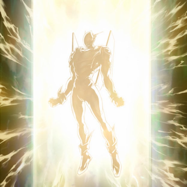

In [ ]:
# load image
example = ds['test'][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

when a spell / trap card is activated : banish 1 face - up " elemental hero " monster you control until the end phase ; negate the activation, and if you do, destroy that card. if you control " elemental hero terra firm


### Ground Truth Text
74095602.jpg

When an "Elemental HERO" Fusion Monster you control is destroyed by battle and sent to the Graveyard: Inflict damage to your opponent equal to its original Level x 300.

In [23]:
from nltk.translate.bleu_score import corpus_bleu
import nltk
nltk.download('punkt')

# Prepare test data
test_dataset = ImageCaptioningDataset(ds['test'], processor)

# DataLoader for test data
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

# Generate captions for test data
generated_captions = []
ground_truth_captions = []

model.eval()
with torch.no_grad():
    for example in ds['test']:
        image = example["image"]
        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        generated_captions.append(generated_caption)
        ground_truth_captions.append(example["desc"])

# Calculate BLEU score
bleu_score = corpus_bleu([[caption] for caption in ground_truth_captions], generated_captions)

print("BLEU Score:", bleu_score)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


BLEU Score: 0.27616330056257143


In [22]:
model.save_pretrained("/content/drive/MyDrive")